# Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

2023-07-10 22:44:58.468943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 22:44:59.162589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load Data

In [2]:
df_assignment_rel=pd.read_csv('./data/assignment_relationships.csv')
df_training=pd.read_csv('./data/training_unit_test_scores.csv')
df_eval=pd.read_csv('./data/evaluation_unit_test_scores.csv')
df_actionlogs=pd.read_csv('./data/action_logs.csv')
df_assignment=pd.read_csv('./data/assignment_details.csv')
df_sequence=pd.read_csv('./data/sequence_details.csv')
df_problem=pd.read_csv('./data/problem_details.csv')
df_total=pd.read_csv('./data/unit_test_scores.csv')
df_hint=pd.read_csv('./data/files/hint_details.csv')
df_explanation=pd.read_csv('./data/explanation_details.csv')


# Score distribution

In [3]:
df_bal=df_total.groupby('score',as_index=False).count()
df_bal['score'] = df_bal['score'].map({0: 'Score 0', 1:'Score 1'})

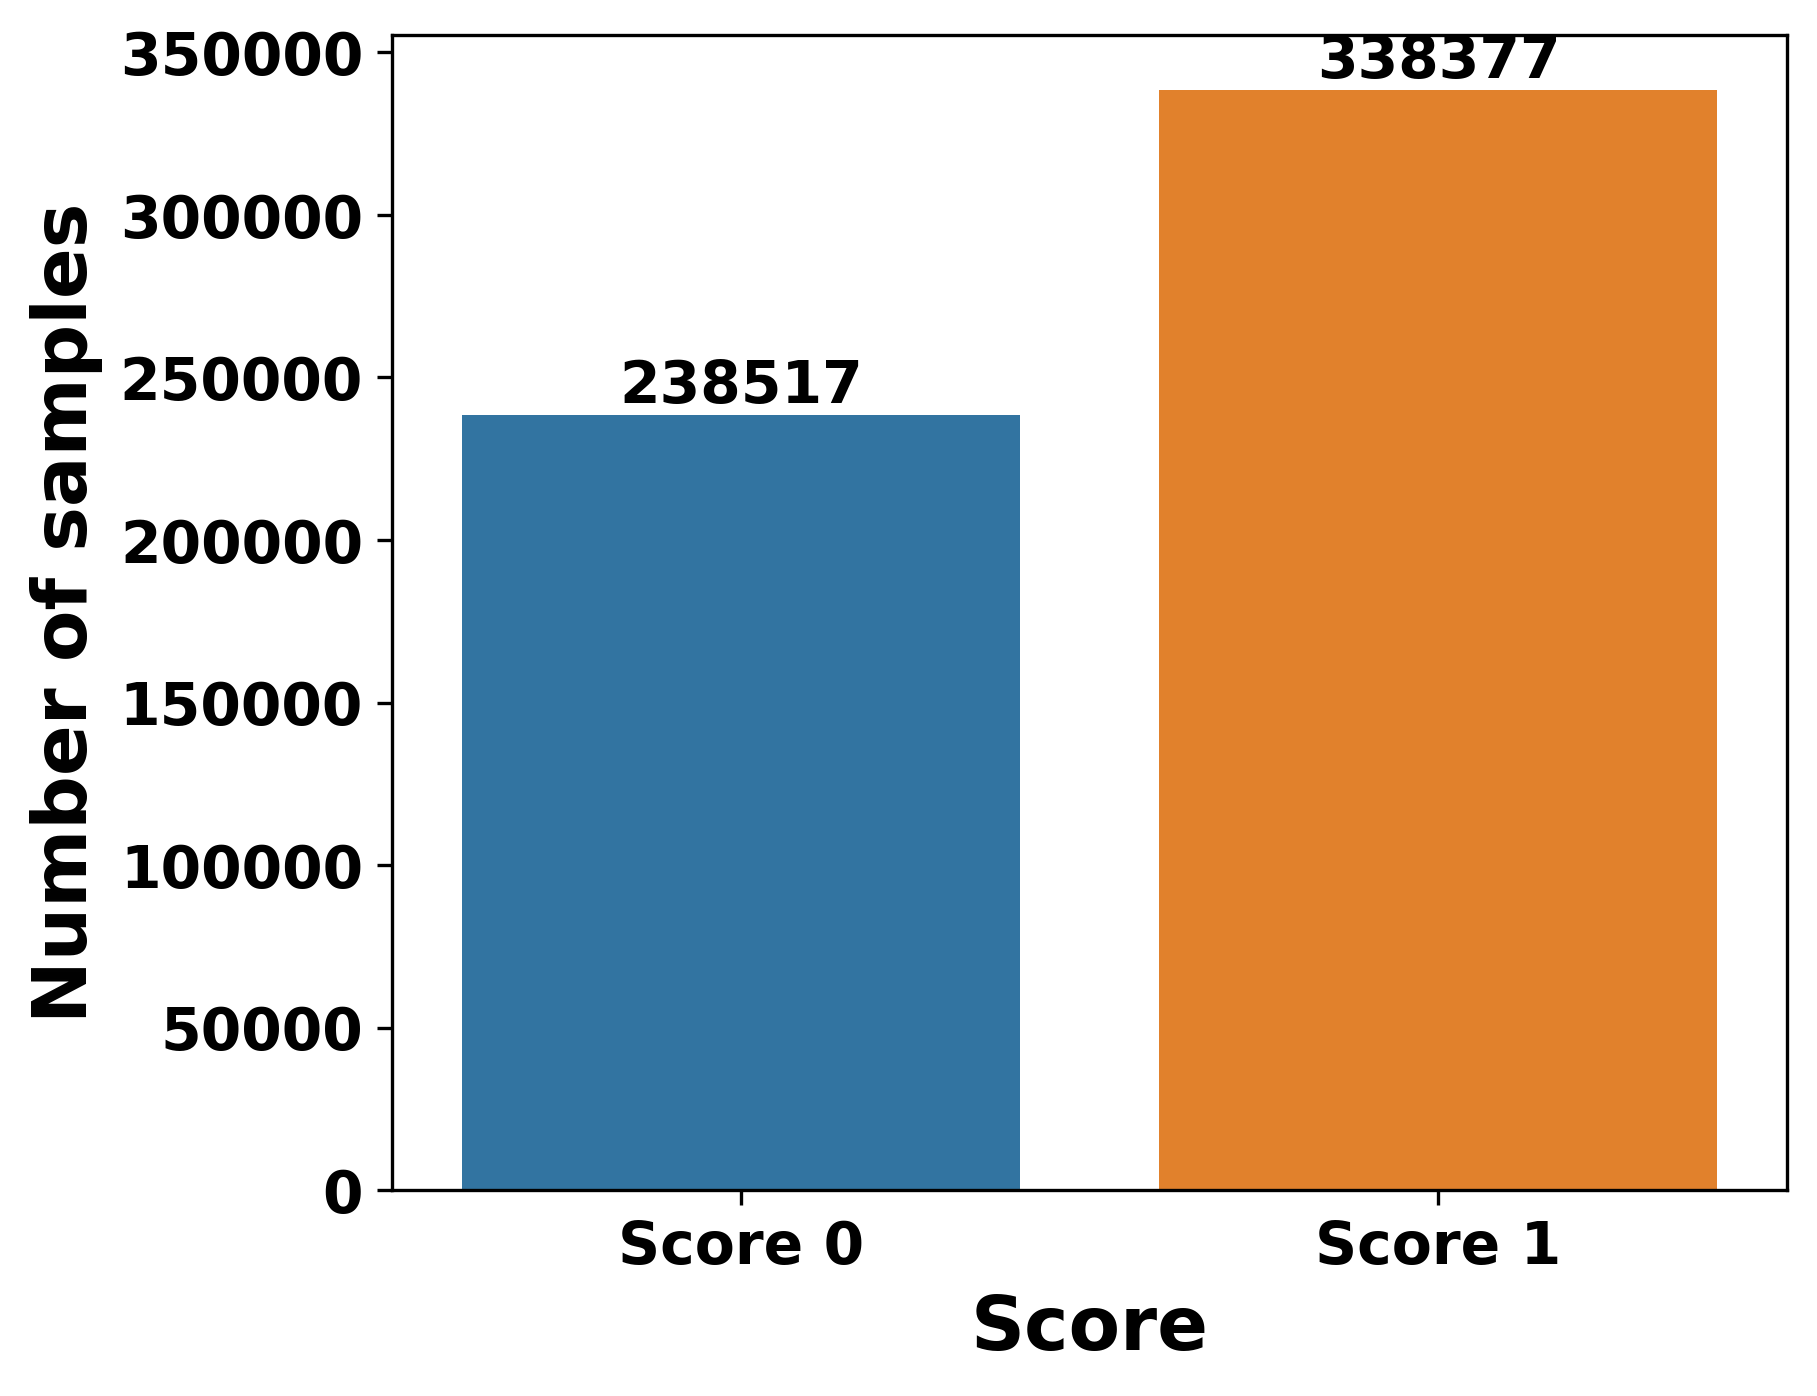

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 5), dpi=300)

ax = sns.barplot(data=df_bal, x='score',y='problem_id')
ax.bar_label(ax.containers[0],fontsize=14, fontweight='bold')

# Set labels and title
plt.xlabel('Score', fontsize=18, fontweight='bold')
plt.ylabel('Number of samples', fontsize=18, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.savefig('score_distribution.pdf',bbox_inches='tight')

# Number of problems per sequence

In [ ]:
#combine train and evaluation data to get features
df_final=pd.concat([df_training,df_eval[['assignment_log_id', 'problem_id', 'score']]])
# get related in-unit assignment log ids using assignment relationships
df_final=df_final.merge(df_assignment_rel,left_on='assignment_log_id',right_on='unit_test_assignment_log_id',how='left')
#filter required features
df_final=df_final[['unit_test_assignment_log_id','problem_id', 'score', 'in_unit_assignment_log_id']]
# get related in-unit assignment log ids using assignment relationships
df_temp=df_total.merge(df_assignment,on='assignment_log_id',how='left')
df_sequence_temp=df_sequence[['sequence_id','sequence_problem_ids']]

df_sequence_temp['sequence_problem_ids']=df_sequence_temp['sequence_problem_ids'].str.replace('[','')
df_sequence_temp['sequence_problem_ids']=df_sequence_temp['sequence_problem_ids'].str.replace(']','')
# use explode to convert list elements to rows
df_explode = df_sequence_temp.assign(sequence_problem_ids=df_sequence_temp.sequence_problem_ids.str.split(",")).explode('sequence_problem_ids')
df_explode=df_explode.drop_duplicates()
df_explode.groupby('sequence_id').count()['sequence_problem_ids'].mean()

In [ ]:
df_total_tem=df_total.merge(df_explode,left_on='problem_id',right_on='sequence_problem_ids')
df_total_tem=df_total_tem[['problem_id','sequence_id']]
df_total_tem=df_total_tem.drop_duplicates()
df_total_tem.groupby('sequence_id').count()['problem_id'].mean()

# Number of problems for each problem type plot

In [8]:
prob_count=df_problem.groupby('problem_type').agg({'problem_id':'count'})
prob_count=prob_count.sort_values('problem_id',ascending=True)

In [10]:

plt.figure(figsize=(12, 10), dpi=1000)
# who v/s fare barplot
sns.barplot(y = prob_count.index,
            x = 'problem_id',
            data = prob_count)

plt.xlabel('Number of problems', fontsize=22, fontweight='bold')
plt.ylabel('Problem type', fontsize=22, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
 

plt.savefig('problem_type_barplot.pdf',bbox_inches='tight')

# Available core tutoring plot

In [14]:
df_actionlogs_temp=df_actionlogs[['problem_id','available_core_tutoring']]
df_actionlogs_temp=df_actionlogs_temp.dropna().drop_duplicates()
df_actionlogs_temp=df_actionlogs_temp.groupby('available_core_tutoring',as_index=False).agg({'problem_id':'count'})
df_actionlogs_temp.available_core_tutoring=df_actionlogs_temp.available_core_tutoring.map({'answer': 'Answer', 'explanation': 'Explanation','hint':'Hint','no_tutoring':'No tutoring'})
df_actionlogs_temp['per']=df_actionlogs_temp['problem_id']/df_actionlogs_temp['problem_id'].sum()

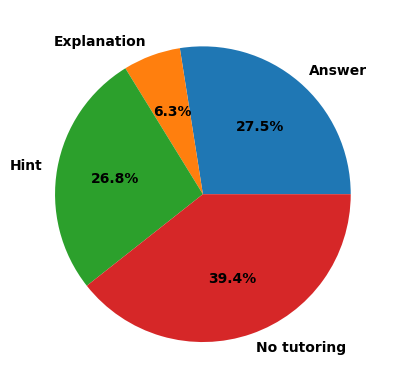

In [15]:
y = np.array(list(df_actionlogs_temp.problem_id))
mylabels = list(df_actionlogs_temp.available_core_tutoring)

plt.pie(y, labels=mylabels, autopct='%1.1f%%',textprops={'weight': 'bold'})
# plt.legend(title="Legend", loc="upper right", bbox_to_anchor=(2, 1))
# Save the figure with a specific DPI
plt.savefig('pie_chart_tutor.pdf', dpi=500)

# Sequence folder path level analysis

In [29]:
df_assignment=df_assignment[['assignment_log_id', 'teacher_id', 'class_id', 'student_id',
       'sequence_id']]
df_training=df_training.merge(df_assignment,left_on='assignment_log_id',right_on='assignment_log_id',how='left')


In [32]:
df_training=df_training.merge(df_sequence,on='sequence_id',how='left')
df_train_seq3=df_training.groupby(['sequence_folder_path_level_2','sequence_folder_path_level_3'],as_index=False).agg({'score':'mean'})
df_train_seq2=df_training.groupby('sequence_folder_path_level_2',as_index=False).agg({'score':'mean'})
df_train_seq3['sequence_folder_path_level_3'] = df_train_seq3['sequence_folder_path_level_3'].apply(lambda x: x.split('-', 1)[1].strip())

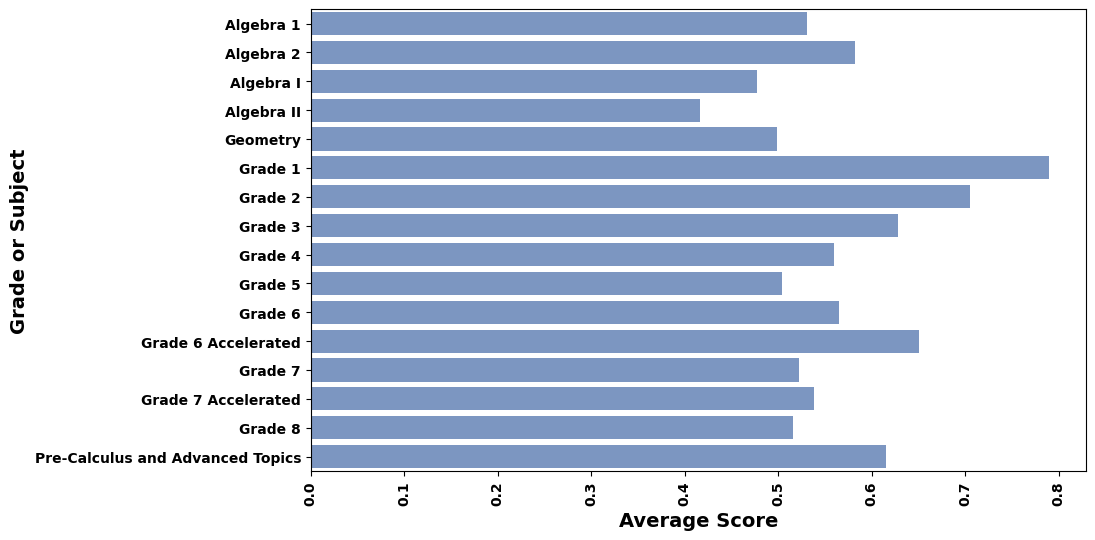

In [33]:
# Create a bar plot
plt.figure(figsize=(10,6))  # Increase the figure size
# Create a bar plot
sns.barplot(data=df_train_seq2, y='sequence_folder_path_level_2', x='score',color='#7093cd')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.ylabel('Grade or Subject', fontsize=14,fontweight='bold')
plt.xlabel('Average Score', fontsize=14,fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.show()

In [34]:
df_train_seq3['new']=df_train_seq3.sequence_folder_path_level_2+' / '+df_train_seq3.sequence_folder_path_level_3
df_train_seq3_bottom10=df_train_seq3.sort_values('score').head(10)
df_train_seq3_top10=df_train_seq3.sort_values('score').tail(10)

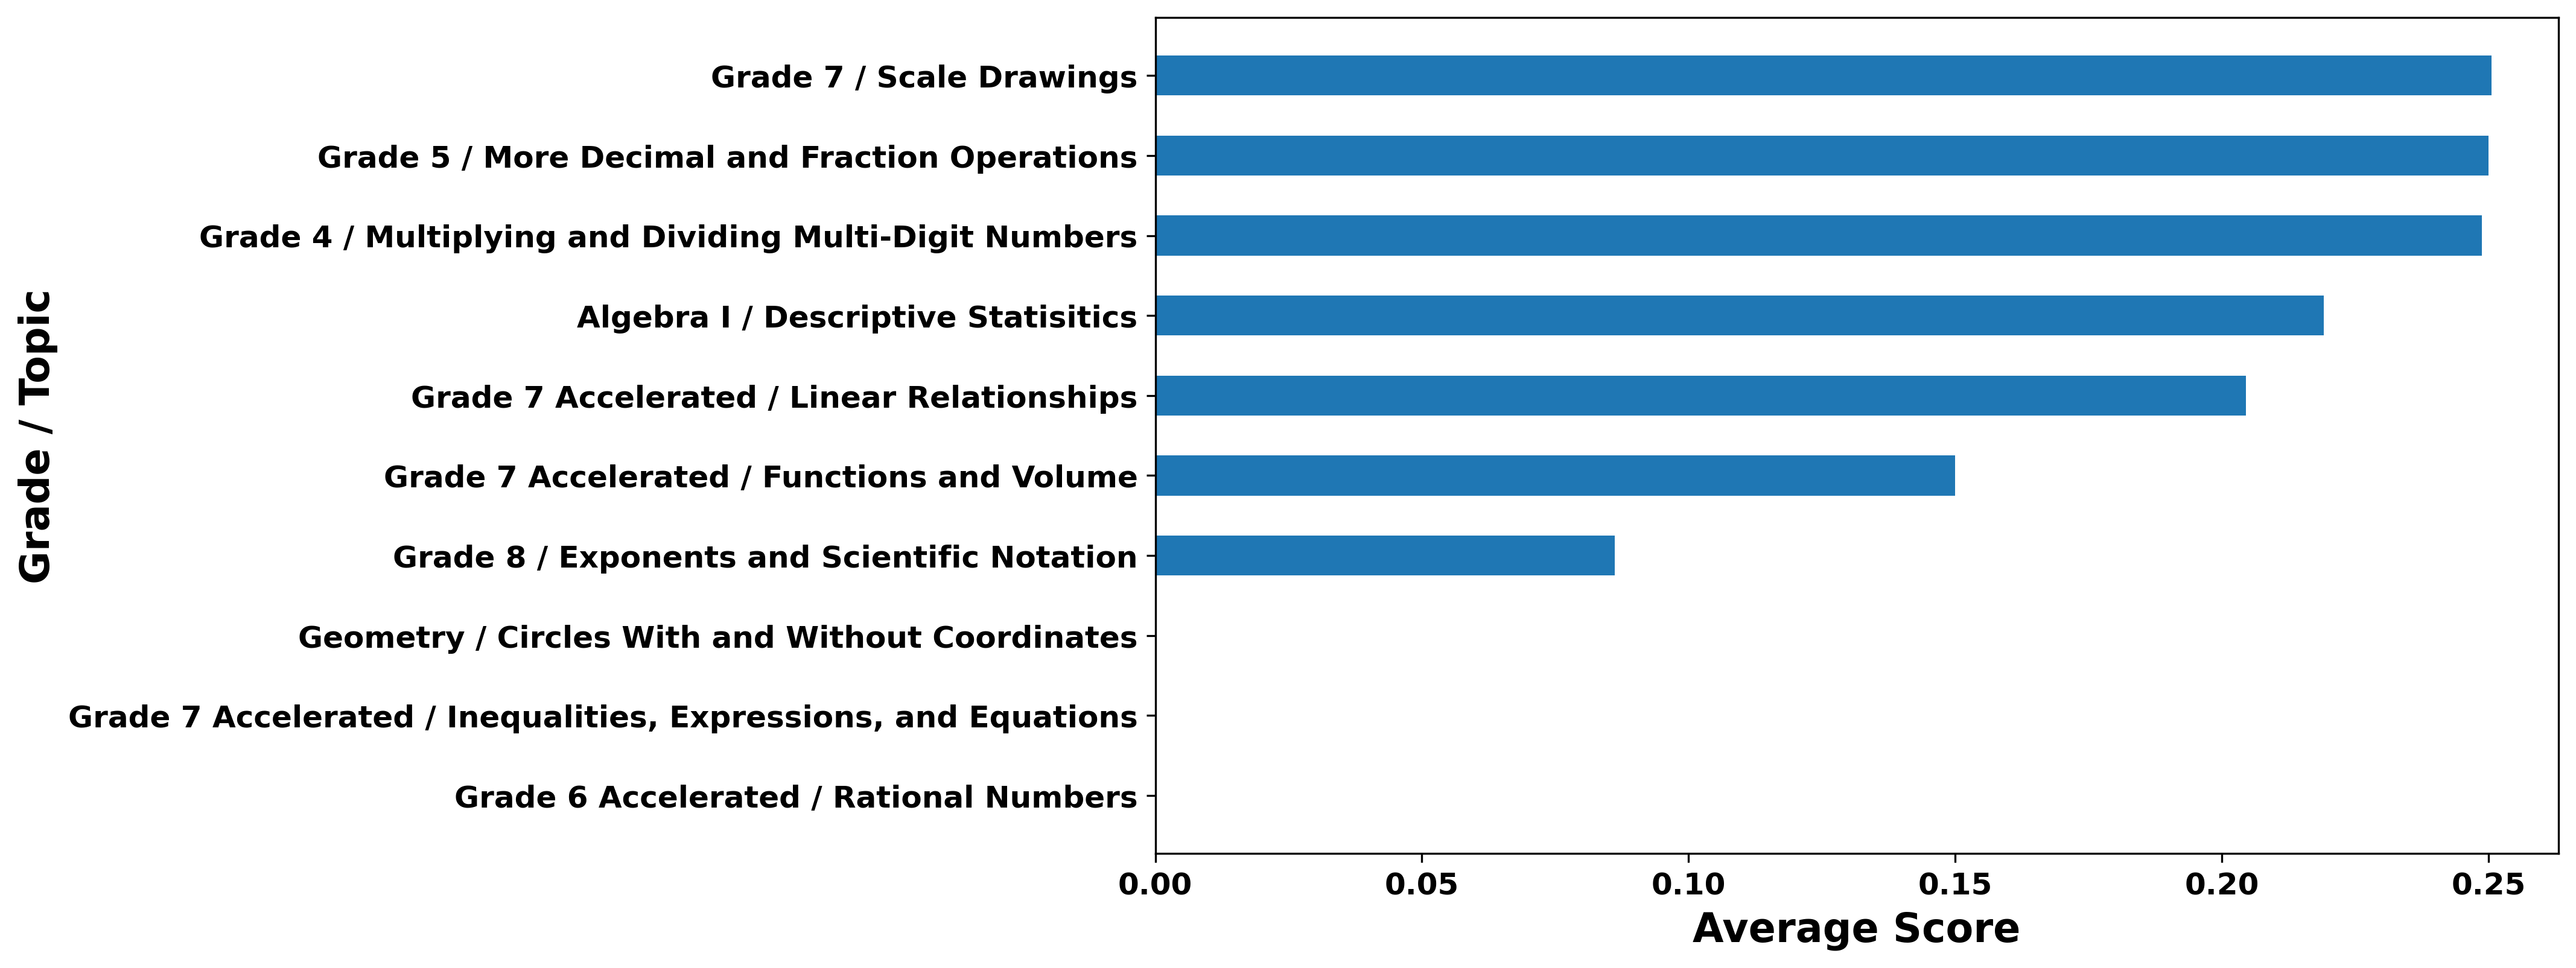

In [35]:
# Increase the figure size
plt.figure(figsize=(10, 6), dpi=300)
# Create a horizontal bar plot
plt.barh(y=df_train_seq3_bottom10['new'],height=0.5, width=df_train_seq3_bottom10['score'])
plt.ylabel('Grade / Topic', fontsize=16, fontweight='bold')
plt.xlabel('Average Score', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.savefig('Grade_topic_bottom.pdf', bbox_inches='tight')
# Display the plot
plt.show()

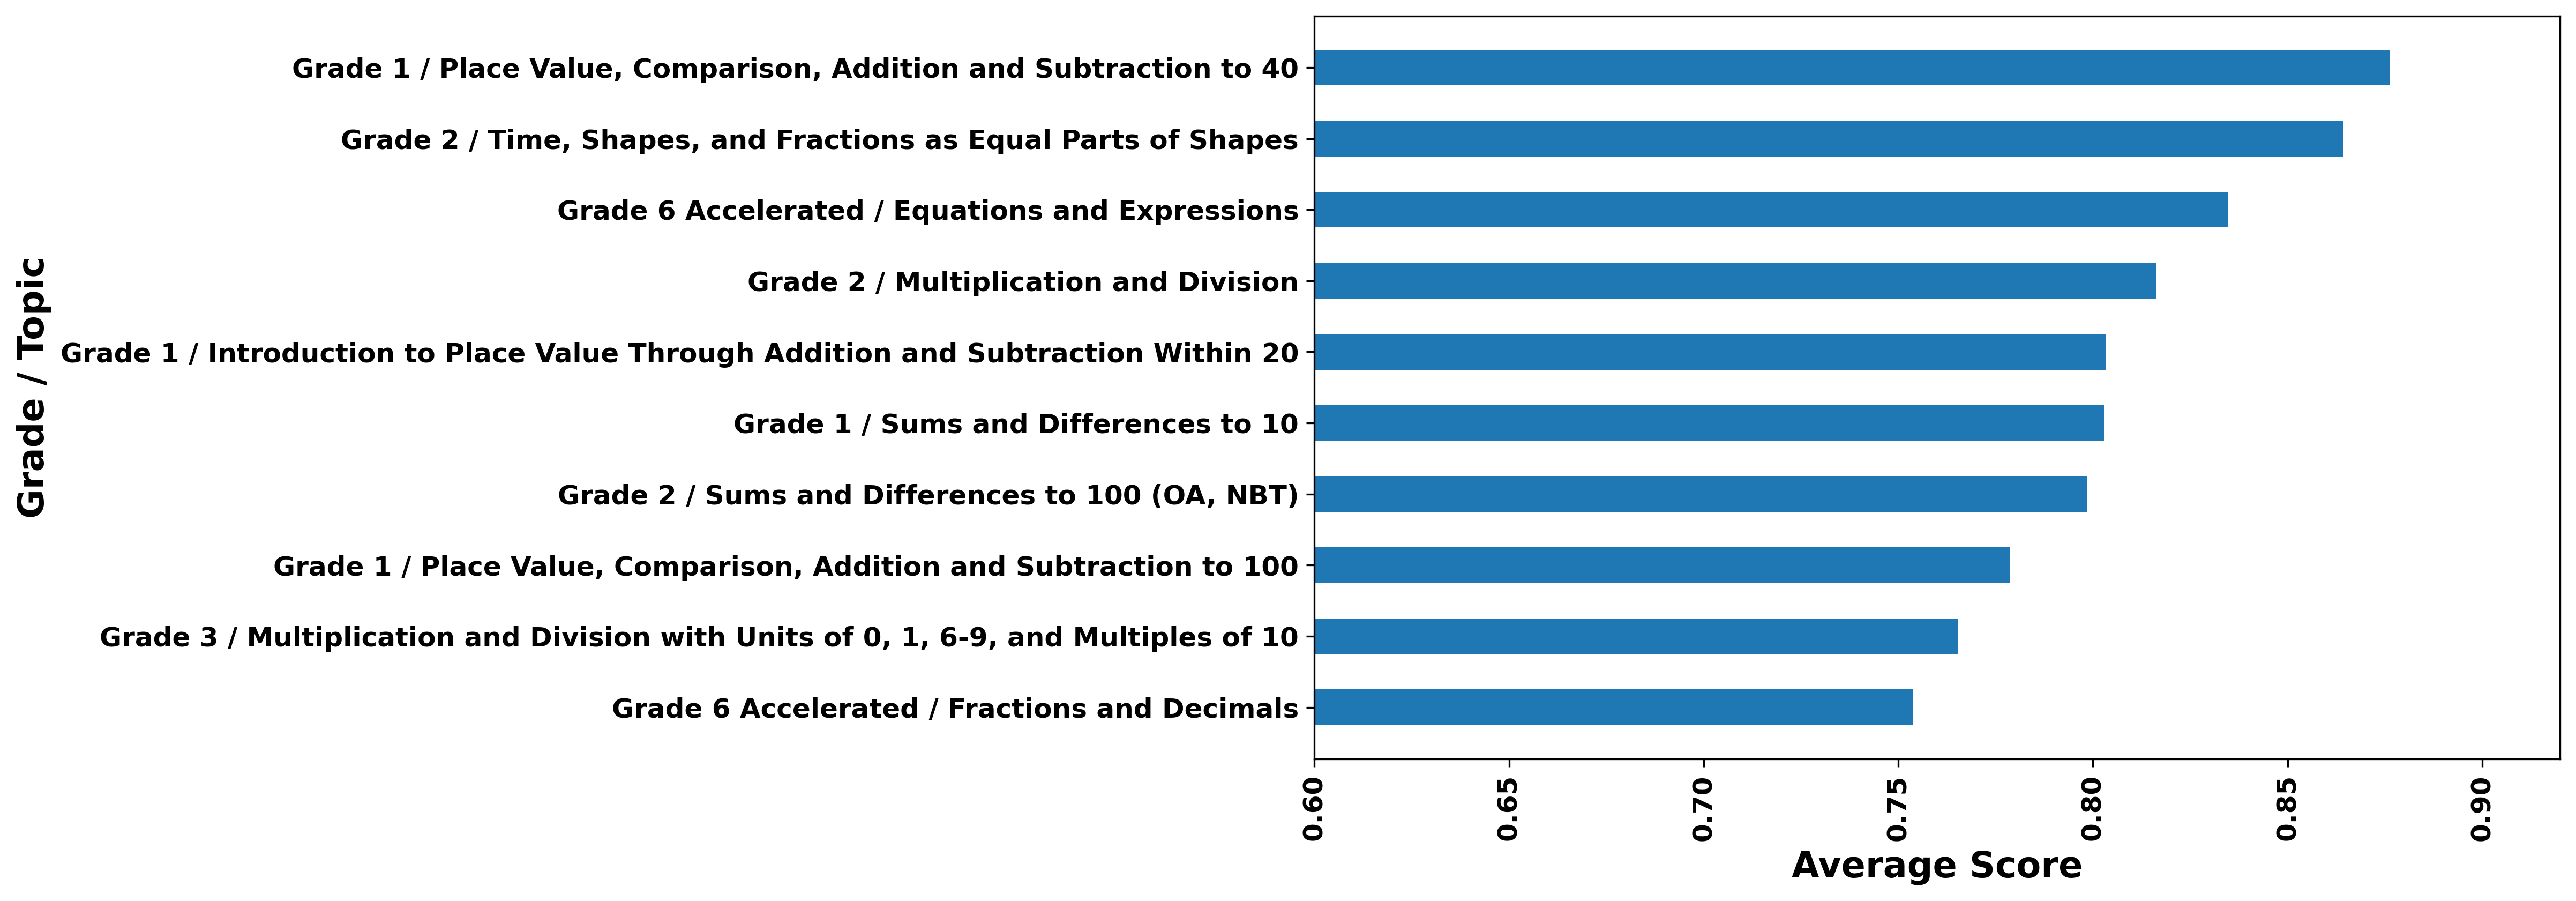

In [36]:

# Increase the figure size
plt.figure(figsize=(10, 6), dpi=300)
# Create a horizontal bar plot
plt.barh(y=df_train_seq3_top10['new'],height=0.5, width=df_train_seq3_top10['score'])
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.xlim(0.6)
plt.ylabel('Grade / Topic', fontsize=16, fontweight='bold')
plt.xlabel('Average Score', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.savefig('Grade_topic_top.pdf', bbox_inches='tight')
# Display the plot
plt.show()